In [34]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mplc
from matplotlib.lines import Line2D
from matplotlib.colors import Normalize, LinearSegmentedColormap
from matplotlib.ticker import LogFormatter
from matplotlib.ticker import ScalarFormatter
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
%matplotlib inline
import seaborn as sns
import os
import random
import pyreadr
import csv

from mpl_toolkits.basemap import Basemap

from scipy.stats import gaussian_kde, binned_statistic
from scipy.stats import skew, kurtosis


# import descartes
import geopandas as gpd
import geodatasets
from shapely.geometry import Point, Polygon
import shapely.geometry
from scipy.optimize import curve_fit
from sklearn.metrics import mean_absolute_error
import osmnx as ox
import pickle

import folium

from scipy.stats import gaussian_kde
from scipy.stats import binned_statistic
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score, mean_squared_error
from scipy.integrate import simps
from scipy import interpolate
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import kstest, anderson, norm, shapiro
from scipy.optimize import curve_fit

from meteostat import Point, Daily

from scipy.stats import pearsonr

%matplotlib inline

import networkx as nx
import collections

import rioxarray

import warnings
warnings.filterwarnings('ignore')


import os


# Define the power-law function
def power_law(x, a, b):
    return a * np.power(x, b)

# Define the linear function
def linear(x, a, b):
    return a + b * x

os.chdir(r'C:\Users\mduran\Desktop\PhD- Patterns and Dynamics in Urban Networks\1- DATA POLLUTION - Scaling laws, pdfs\RESULTS_GLOBAL') 

In [2]:
#STEP RESOLUTION DEGREES TO meters

from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):

    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371000 # Radius of earth in meters
    return c * r 

haversine(1,1,1.01,1)

1111.779911186028

# SIMULATION

## CLIMATE VARIABLES

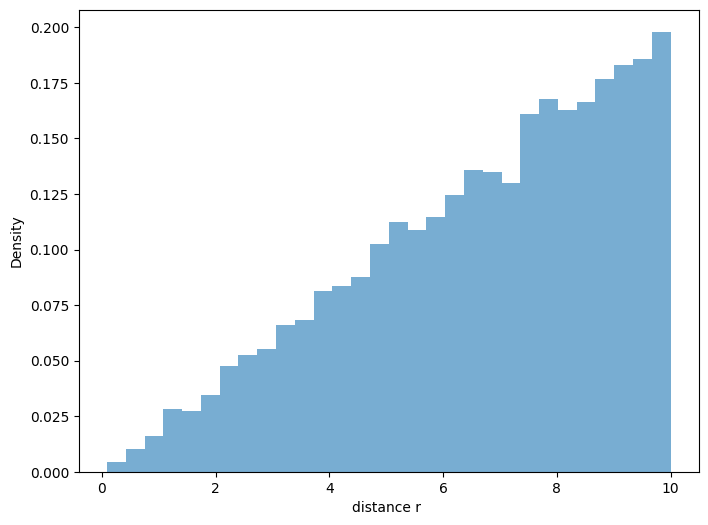

[1.23116175 1.15654727 1.09046001 1.0315172  0.97861972 0.93088288
 0.88758662 0.84813886 0.81204832 0.77890391 0.74835902 0.72011938
 0.69393352 0.66958523 0.64688767 0.62567845 0.60581583 0.58717552
 0.56964805 0.55313666 0.53755548 0.52282806 0.50888609 0.49566838
 0.48311991 0.47119111 0.45983719 0.44901757 0.4386954  0.42883715
 0.41941222 0.41039266 0.40175287 0.39346936 0.38552053 0.37788651
 0.37054895 0.36349091 0.35669673 0.35015187 0.34384287 0.33775718
 0.33188318 0.32620999 0.3207275  0.31542624 0.31029739 0.30533265
 0.30052429 0.29586502 0.29134802 0.28696686 0.28271552 0.27858831
 0.27457986 0.27068513 0.26689934 0.26321798 0.2596368  0.25615176
 0.25275903 0.24945501 0.24623624 0.24309949 0.24004165 0.23705977
 0.23415108 0.23131289 0.22854269 0.22583805 0.22319668 0.22061638
 0.21809506 0.21563072 0.21322144 0.21086541 0.20856088 0.20630617
 0.2040997  0.20193992 0.19982537 0.19775465 0.1957264  0.19373934
 0.19179222 0.18988384 0.18801307 0.1861788  0.18437998 0.1826

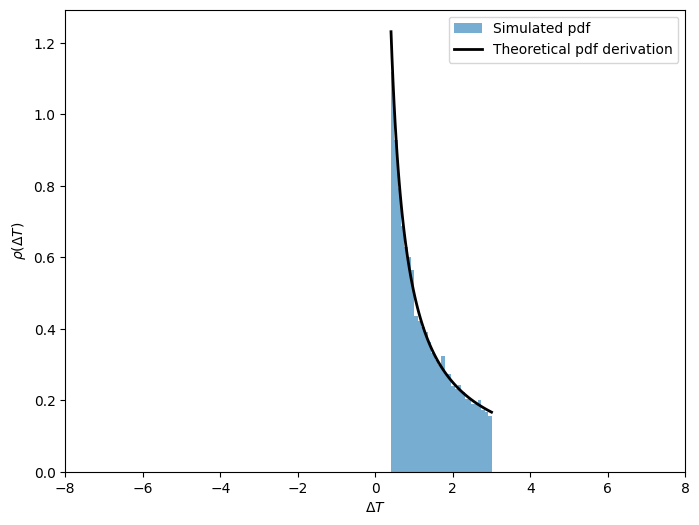

In [3]:
# Parameters
T0 = 3  # Peak temperature at the city center
sigma_r = 5  # Parameter controlling the rate of temperature decay
R = 10  # Radius of the city

# Number of samples
n_samples = 10000

rs = []
Ts = []


for i in range(n_samples):
    r = R * np.sqrt(np.random.uniform(0,1))
    T = T0 * np.exp(-r**2 / (2 * sigma_r**2))
    rs.append(r)
    Ts.append(T0 * np.exp(-r**2 / (2 * sigma_r**2)))

plt.figure(figsize=(8,6))

plt.hist(rs, bins=30, density=True, alpha=0.6, label='Simulated r')
plt.xlabel('distance r ')
plt.ylabel('Density')
plt.show()

plt.figure(figsize=(8,6))

plt.hist(Ts, bins=30, density=True, alpha=0.6, label='Simulated pdf')
plt.xlabel(r'$\Delta T$')
plt.ylabel(r'$\rho(\Delta T)$')

x = np.linspace(min(Ts), T0, 100)
p = (2*sigma_r**2)/(R**2*x)
print(p)
p = 1/np.log(T0/min(Ts)) * 1/x
print(p)
plt.plot(x, p, 'k', linewidth=2, label=f'Theoretical pdf derivation')

plt.xlim(-8,8)

plt.legend()
# plt.savefig('Simulated_pdf_T.png', dpi=300)
plt.show()

Noise sigma: 0.0 | KS test p-value: 0.000
Noise sigma: 0.5 | KS test p-value: 0.000


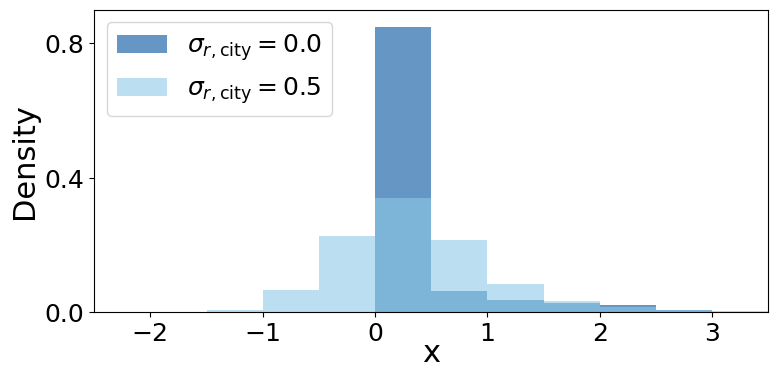

In [29]:
# Parameters for the deterministic model
T0 = 2.5        # Peak temperature at the city center
sigma_r = 5     # Controls the rate of temperature decay
R = 25          # Radius of the city
n_samples = 2500

# Sample the deterministic temperature field
rs = []
Td = []  # Deterministic temperatures without noise
for i in range(n_samples):
    # Sample r uniformly in area: r = R*sqrt(u), where u ~ U(0,1)
    r = R * np.sqrt(np.random.uniform(0, 1))
    T = T0 * np.exp(-r**2 / (2 * sigma_r**2))
    rs.append(r)
    Td.append(T)

# Define constant bin edges across all noise levels
bins = np.linspace(-2.5, 4, 14)

# Define noise levels and assign a color to each
noise_levels = [0, 0.5]
colors = ['#00509d', '#8ecae6']  # red-ish and blue-ish; you can change these

plt.figure(figsize=(8, 4))

for sigma_noise, color in zip(noise_levels, colors):
    # Add Gaussian noise to the deterministic temperatures
    noise = np.random.normal(loc=0, scale=sigma_noise, size=n_samples)
    T_obs = np.array(Td) + noise + 0.15
    
    # Compute mean and std of the noisy temperatures
    mu = np.mean(T_obs)
    std = np.std(T_obs)
    
    # Plot histogram using weights so each bin shows the fraction of samples (0 to 1)
    plt.hist(T_obs, bins=bins, weights=np.ones_like(T_obs) / n_samples, alpha=0.6, 
             label=rf"$\sigma_{{r,\mathrm{{city}}}} = {sigma_noise:.1f}$", color=color)
    
    # KS test for goodness of fit against a Gaussian distribution
    D, p_value = kstest(T_obs, 'norm', args=(mu, std))
    print(f"Noise sigma: {sigma_noise:.1f} | KS test p-value: {p_value:.3f}")

plt.xlabel('x', fontsize=22, labelpad=-5)
plt.ylabel('Density', fontsize=22)
plt.yticks([0,0.4,0.8])
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)
plt.legend(fontsize=18, loc='upper left')

plt.tight_layout(pad=1.5)
plt.xlim(-2.5, 3.5)
plt.ylim(0, 0.9)

plt.savefig('climate_variables_model_with_whitenoise.svg', format='svg', dpi=600, bbox_inches='tight')
plt.show()


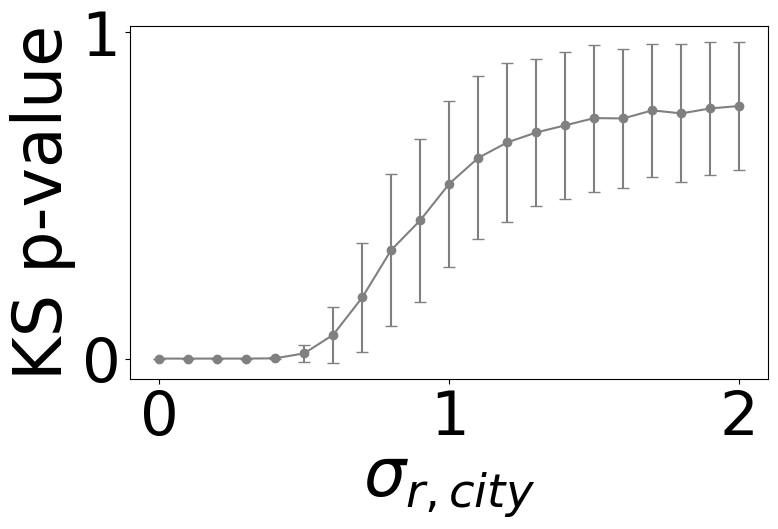

'\n# ----- B) Anderson–Darling Statistics -----\n# Typically, if AD statistic is small (< critical value), data is more normal.\nplt.figure(figsize=(8, 5))\nplt.errorbar(noise_sigmas-0.1, ad_mean_statistics, yerr=ad_std_statistics,\n             fmt=\'-o\', capsize=4, color=\'r\')\nplt.xlabel(r\'Residual variability, $\\sigma_r$\', fontsize=14)\nplt.ylabel(\'A-D Test Statistic\', fontsize=14)\n\n# plt.savefig(\'test_gaussian_AD.svg\', format=\'svg\', dpi=600, bbox_inches=\'tight\')\n\nplt.show()\n\n\n# Print the averaged p-values for inspection\n# print("Averaged KS p-values:", mean_p_values)\n'

In [27]:
# ----- Model Parameters -----
T0 = 2.5        # Peak temperature at the city center
sigma_r = 5   # Controls the rate of temperature decay
R = 25        # Radius of the city
n_samples = 2500
n_trials = 1000  # Number of realizations for averaging

# ----- Sampling Deterministic Temperature Field -----
# We'll generate the deterministic temperatures only once since they're fixed
rs = []
Td = []  # Deterministic temperatures without noise
for _ in range(n_samples):
    r = R * np.sqrt(np.random.uniform(0, 1))
    T = T0 * np.exp(-r**2 / (2 * sigma_r**2))
    rs.append(r)
    Td.append(T)
Td = np.array(Td)

# ----- Noise Levels and KS Test Averaging -----
noise_sigmas = np.linspace(0, 2, 21)

# A)
mean_p_values = []
std_p_values = []

# B) Anderson–Darling (gives a statistic, not a direct p-value)
ad_mean_statistics = []
ad_std_statistics  = []

for sigma_noise in noise_sigmas:
    p_values = []
    ad_stats = []
    
    for _ in range(n_trials):
        if sigma_noise == 0:
            T_obs = Td
        else:
            noise = np.random.normal(loc=0, scale=sigma_noise, size=n_samples)
            T_obs = Td + noise

        mu = np.mean(T_obs)
        std = np.std(T_obs)

        # A) KS test: compare the sample distribution to N(mu, std)
        D, p_value = kstest(T_obs, 'norm', args=(mu, std))
        p_values.append(p_value)

        # ----- B) Anderson–Darling Test -----
        ad_result = anderson(T_obs, dist='norm')
        ad_stats.append(ad_result.statistic)
    
        
    mean_p_values.append(np.mean(p_values))
    std_p_values.append(np.std(p_values))

    ad_mean_statistics.append(np.mean(ad_stats))
    ad_std_statistics.append(np.std(ad_stats))

plt.figure(figsize=(8, 5.5))
plt.errorbar(noise_sigmas, mean_p_values, yerr=std_p_values,
             fmt='-o', capsize=4, color='grey')
plt.xticks([0,1,2])
plt.yticks([0,1])
plt.tick_params(axis='x', labelsize=44)
plt.tick_params(axis='y', labelsize=44)
plt.xlabel(r'$\sigma_{r,city}$', fontsize=48)
plt.ylabel('KS p‑value', fontsize=48)

mean_p_values_arr = np.array(mean_p_values)
if np.any(mean_p_values_arr >= 0.05):
    threshold_idx = np.argmax(mean_p_values_arr >= 0.05)

    sigma_threshold = noise_sigmas[threshold_idx-1] if threshold_idx > 0 else noise_sigmas[0] 
    sigma_threshold = sigma_threshold
    threshold_x = sigma_threshold 

plt.tight_layout(pad=1.5)
plt.savefig('test_gaussian_KS.svg', format='svg', dpi=600, bbox_inches='tight')
plt.show()


## STREET NETWORK

σ_log=0.0  →  KS p‑value = 0.000
σ_log=1.0  →  KS p‑value = 0.000


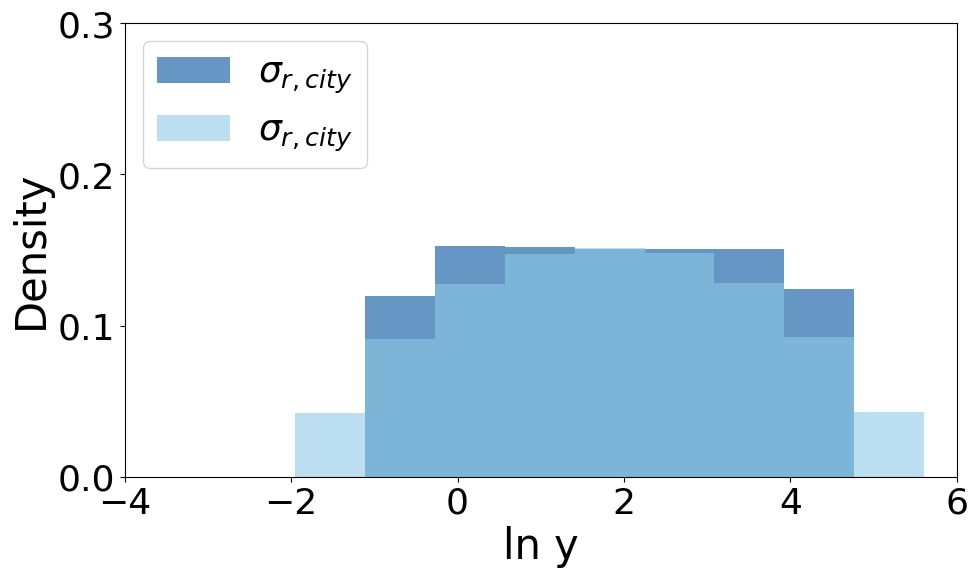

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kstest, norm

# -------------------------------------------------
# Parameters of the street‑intersection profile
n0   = 100      # central amplitude
lam  = 7.5      # decay length  λ  (km)
R    = 25       # city radius   (km)
N    = 50000     # samples
sigma_ln_levels = [0.0, 1.0]      # multiplicative noise strengths
colors = ['#00509d', '#8ecae6']   # dark / light blue
# -------------------------------------------------

# Deterministic ln n(r)
r = R * np.sqrt(np.random.rand(N))
y_det = np.log(n0) - r**2 / (2*lam**2)   # y = ln n

# Common histogram bins (log‑space)
bins = np.linspace(y_det.min()-1, y_det.max()+1, 10)

plt.figure(figsize=(10, 6))

for s_ln, c in zip(sigma_ln_levels, colors):
    # Add white noise in log‑space
    y_obs = y_det + np.random.normal(0, s_ln, size=N)

    # Histogram as density (each bar integrates to 1)
    plt.hist(y_obs, bins=bins, weights=np.ones_like(y_obs)/N,
             alpha=0.6, color=c, label=r"$\sigma_{r,city}$")

    # Normal fit + KS test in log‑space
    mu, sd = norm.fit(y_obs)
    D, p_val = kstest(y_obs, 'norm', args=(mu, sd))
    print(f"σ_log={s_ln:.1f}  →  KS p‑value = {p_val:.3f}")

plt.xlabel('ln y', fontsize=30)
plt.ylabel('Density', fontsize=30)
plt.tick_params(axis='x', labelsize=26)
plt.tick_params(axis='y', labelsize=26)
plt.xlim(-4,6)
plt.ylim(0,0.3)
plt.yticks([0, 0.1, 0.2, 0.3])
plt.legend(fontsize=26, loc='upper left')
plt.tight_layout(pad=1.5)
plt.savefig('street_network_model_with_whitenoise.svg', format='svg', dpi=600, bbox_inches='tight')
plt.show()


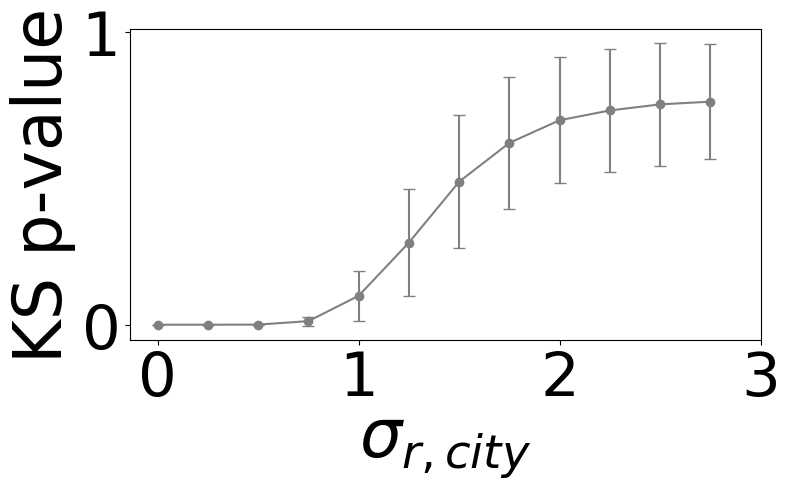

In [35]:
# -------------------------------------------------
# Deterministic profile  ln n(r)
n0, lam, R = 100, 7.5, 25       # n₀, λ, radius (km)
N          = 2500               # samples per realisation
n_trials   = 1000               # Monte‑Carlo repetitions
# -------------------------------------------------

sigma_ln_grid = np.arange(0, 3, 0.25)

# Pre‑compute deterministic ln n
r  = R * np.sqrt(np.random.rand(N))
y_det = np.log(n0) - r**2 / (2*lam**2)

# Sweep multiplicative noise levels
ks_mean, ks_std = [], []
ad_mean, ad_std = [], []

for s_ln in sigma_ln_grid:
    ks_pvals, ad_stats = [], []

    for _ in range(n_trials):
        y_obs = y_det + np.random.normal(0, s_ln, size=N)

        # KS test vs Normal in log‑space
        mu, sd = norm.fit(y_obs)
        _, p_ks = kstest(y_obs, 'norm', args=(mu, sd))
        ks_pvals.append(p_ks)

        # Anderson–Darling statistic
        ad_stat = anderson(y_obs, dist='norm').statistic
        ad_stats.append(ad_stat)

    ks_mean.append(np.mean(ks_pvals))
    ks_std.append(np.std(ks_pvals))
    ad_mean.append(np.mean(ad_stats))
    ad_std.append(np.std(ad_stats))

# -------------------------------------------------
# Plot KS mean p‑value ± std vs σ_log
# -------------------------------------------------
plt.figure(figsize=(8, 5))
plt.errorbar(sigma_ln_grid, ks_mean, yerr=ks_std,
             fmt='-o', capsize=4, color='grey')
plt.xticks([0,1,2,3])
plt.yticks([0,1])
plt.tick_params(axis='x', labelsize=44)
plt.tick_params(axis='y', labelsize=44)
plt.xlabel(r'$\sigma_{r,city}$', fontsize=48)
plt.ylabel('KS p‑value', fontsize=48)
plt.tight_layout()
plt.savefig('test_lognormal_KS.svg', format='svg', dpi=600, bbox_inches='tight')
plt.show()

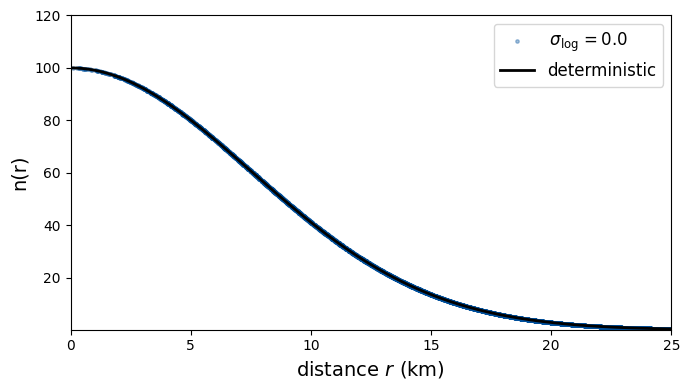

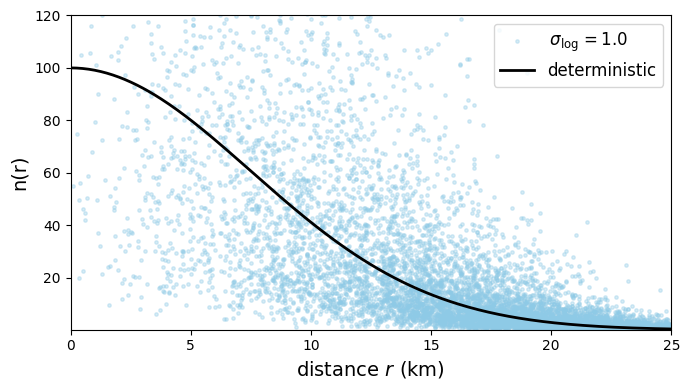

In [150]:
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------------------------
# Synthetic street‑intersection field
n0, lam, R = 100, 7.5, 25          # amplitude, decay length, radius (km)
N          = 10_000                # samples
sig_ln_set = [0.0, 1.0]            # multiplicative noise strengths
colors     = ['#00509d', '#8ecae6']
# -------------------------------------------------

# Sample radii uniformly in area
r = R * np.sqrt(np.random.rand(N))

# Deterministic profile in linear space
n_det = n0 * np.exp(-r**2 / (2*lam**2))

# For a smooth reference curve
r_smooth = np.linspace(0, R, 300)
n_curve  = n0 * np.exp(-r_smooth**2 / (2*lam**2))

for s_ln, col in zip(sig_ln_set, colors):

    plt.figure(figsize=(7, 4))
    
    # multiplicative white noise  (additive in log space)
    n_obs = n_det * np.exp(np.random.normal(0, s_ln, size=N))
    plt.scatter(r, n_obs, s=6, alpha=0.35, color=col,
                label=rf'$\,\sigma_{{\log}}={s_ln:.1f}$')

    # deterministic curve
    plt.plot(r_smooth, n_curve, 'k-', lw=2, label='deterministic')

    plt.xlabel('distance $r$ (km)', fontsize=14)
    plt.ylabel('n(r)', fontsize=14)
    # plt.yscale('log')                      # log‑y highlights log‑normal spread
    plt.xlim(0, R); plt.ylim(0.1, n0*1.2)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.savefig('decay_lognormal_example.svg', format='svg', dpi=600, bbox_inches='tight')
    plt.show()


# REAL DATA

In [11]:
net_type = 'drive'

T_type = 'mean'

POPULATION = 'no'

PM = '25'

In [12]:
cities = [
    'Barcelona', 'Montpellier', 'Rome', 'Naples', 'Porto', 'Sevilla', 'Alicante', 'Valencia', 'Bologna', 'Padua', 'Turin',
    'Madrid', 'Murcia', 'Genoa', 'Milan', 'Lisbon', 'Palma_de_Mallorca', 'Split','Marseille', 'Palermo','Nice', 'Malaga', 'Bari', 

    'Antwerp', 'Amsterdam', 'Brussels', 'London', 'Paris', 'Luxembourg', 'Rotterdam', 'Lille', 'Basel', 'Birmingham', 'Nantes', 'Strasbourg',
    'Zurich', 'Frankfurt', 'Vienna', 'Munich', 'Bratislava', 'Prague', 'Geneva', 'Bordeaux', 'Utrecht', 
    'Liege', 'Bilbao', 'Charleroi', 'Wroclaw', 'Leipzig', 'Berlin', 'Hamburg', 'Lodz', 'Warsaw', 'Edinburgh', 
    'Glasgow', 'Cologne', 'Dusseldorf', 'Newcastle', 'Ghent', 'Dublin', 'Toulouse', 'Leeds', 'Lyon',

    'Tallinn','Reykjavik', 'Copenhagen', 'Goteborg', 'Helsinki', 'Stockholm', 'Oslo', 'Tartu', 'Riga', 'Klaipeda', 'Vilnius', 'Gdansk',

    'Sofia', 'Zagreb', 'Budapest', 'Szeged', 'Brasov', 'Bucharest', 'Ljubljana', 'Sarajevo', 'Gyor','Thessaloniki','Debrecen','Belgrado', 'Podgorica',
    'Trieste', 'Miskolc', 'Kosice', 'Krakow', 'Pecs', 'Varna', 'Skopje', 'Novi_Sad', 'Graz', 'Athens', 'Tirana', 'Cluj_Napoca', 
    
    'Accra', 'Addis_Abeba', 'Amman', 'Auckland', 'Bogota', 'Buenos_Aires', 'Cairo', 'Cape_Town', 'Chennai', 'Curitiba', 'Dakar', 'Dhaka', 'Dubai', 
    'Ho_Chi_Minh', 'Hong_Kong', 'Houston', 'Islamabad', 'Istanbul', 'Jakarta', 'Karachi', 'Lagos', 'Lima', 'Los_Angeles', 'Marrakesh', 'Medina', 
    'Melbourne', 'Mexico_City', 'Mogadishu', 'Moscow', 'Nairobi', 'Nanjing', 'New_York', 'Phoenix', 'Rabat', 'Salvador', 'Santiago', 'Singapore', 
    'Sydney', 'Teheran', 'Tokyo', 'Toronto', 'Tschwane']

In [13]:
size = '1000'
SIZE = 1000
cell_size_meters = 1000

In [14]:
# OPEN MERGE T AND POPULATION CSV FILES

os.chdir(r'C:\Users\mduran\Desktop\PhD- Patterns and Dynamics in Urban Networks\1- DATA POLLUTION - Scaling laws, pdfs\RESULTS_GLOBAL\dataframes_2') 

pop_T_NETWORK_dic = {}

for city in cities:
    
    pop_T_NETWORK_dic[city] = pd.read_csv(city+'_pop_T'+T_type+'_PM'+PM+'_NETWORK_'+size+'.csv')

    if 'population' in pop_T_NETWORK_dic[city].columns:
            pop_T_NETWORK_dic[city].rename(columns={'population': 'popu'}, inplace=True)

for city in cities:

    pop_T_NETWORK_dic[city].replace([np.inf, -np.inf], np.nan, inplace=True)

    pop_T_NETWORK_dic[city] = pop_T_NETWORK_dic[city].dropna(subset=['T']).reset_index(drop=True) # specific column
    pop_T_NETWORK_dic[city] = pop_T_NETWORK_dic[city].dropna(subset=['node']).reset_index(drop=True)
    pop_T_NETWORK_dic[city] = pop_T_NETWORK_dic[city].dropna(subset=['PM'+PM]).reset_index(drop=True)


if POPULATION == 'yes':
    for city in cities:
        pop_T_NETWORK_dic[city] = pop_T_NETWORK_dic[city][pop_T_NETWORK_dic[city]['popu'] > 0]

In [15]:
os.chdir(r'C:\Users\mduran\Desktop\PhD- Patterns and Dynamics in Urban Networks\1- DATA POLLUTION - Scaling laws, pdfs\RESULTS_GLOBAL\dataframes_2')

# Función para cargar los centros de ciudad desde el CSV
def load_centers(csv_file="city_centers.csv"):
    centers = {}
    with open(csv_file, "r") as file:
        reader = csv.DictReader(file)
        for row in reader:
            centers[row["City"]] = (float(row["Longitude"]), float(row["Latitude"]))
    return centers

# Carga de los centros en un diccionario global
city_centers = load_centers()

def calculate_rescaled_distance():
    DISTANCES = []
    k = (pop_T_NETWORK_dic[city]['popu'].sum() / Pmax)**(1/3)
    
    # Usamos el centro precargado del CSV para la ciudad
    city_center_lon, city_center_lat = city_centers[city]
    
    for i, j in zip(pop_T_NETWORK_dic[city]['x'], pop_T_NETWORK_dic[city]['y']):
        r = haversine(city_center_lon, city_center_lat, i, j)
        DISTANCES.append(r / k)
        
    return DISTANCES

def calculate_distance():
    DISTANCES = []
    
    # Usamos el centro precargado del CSV para la ciudad
    city_center_lon, city_center_lat = city_centers[city]
    
    for i, j in zip(pop_T_NETWORK_dic[city]['x'], pop_T_NETWORK_dic[city]['y']):
        r = haversine(city_center_lon, city_center_lat, i, j)
        DISTANCES.append(r)
        
    return DISTANCES


boundary_radius = 100000

Pmax = 0

for city in cities:
    # print(city)
    P = pop_T_NETWORK_dic[city]['popu'].sum()
    # print(P)
    if P > Pmax:
        Pmax = P
        
r_rescaled_dic = {}
r_dic = {}

for city in cities:

    r_rescaled_dic[city] = calculate_rescaled_distance()
    r_dic[city] = calculate_distance()

for city in cities:

    pop_T_NETWORK_dic[city]['r_rescaled'] = r_rescaled_dic[city]
    pop_T_NETWORK_dic[city]['r'] = r_dic[city]

    # if pop_T_NETWORK_dic[city]['r_rescaled'].max() < boundary_radius:
        # print(city, pop_T_NETWORK_dic[city]['r_rescaled'].max())

boundary_radius = 100000

for city in cities:
    pop_T_NETWORK_dic[city] = pop_T_NETWORK_dic[city][pop_T_NETWORK_dic[city]['r_rescaled'] < boundary_radius]
    


In [16]:
# OPEN MERGE T AND POPULATION CSV FILES

os.chdir(r'C:\Users\mduran\Desktop\PhD- Patterns and Dynamics in Urban Networks\1- DATA POLLUTION - Scaling laws, pdfs\RESULTS_GLOBAL\dataframes_2') 

OUTSIDE_TEMP_dic = {}

for city in cities:

    OUTSIDE_TEMP_dic[city] = pd.read_csv(city+'_pop_T'+T_type+'_PM'+PM+'_NETWORK_1000.csv')

    OUTSIDE_TEMP_dic[city].replace([np.inf, -np.inf], np.nan, inplace=True)
    OUTSIDE_TEMP_dic[city] = OUTSIDE_TEMP_dic[city].dropna(subset=['T']).reset_index(drop=True)
    # OUTSIDE_TEMP_dic[city] = OUTSIDE_TEMP_dic[city][OUTSIDE_TEMP_dic[city]['node'].isna()]
    OUTSIDE_TEMP_dic[city] = OUTSIDE_TEMP_dic[city][OUTSIDE_TEMP_dic[city]['node'] == 1]

for city in cities:
    pop_T_NETWORK_dic[city]['deltaT'] = pop_T_NETWORK_dic[city]['T'] - OUTSIDE_TEMP_dic[city]['T'].mean()
    

In [17]:
# OPEN MERGE T AND POPULATION CSV FILES

os.chdir(r'C:\Users\mduran\Desktop\PhD- Patterns and Dynamics in Urban Networks\1- DATA POLLUTION - Scaling laws, pdfs\RESULTS_GLOBAL\dataframes_2') 

OUTSIDE_PM_dic = {}

for city in cities:

    OUTSIDE_PM_dic[city] = pd.read_csv(city+'_pop_T'+T_type+'_PM'+PM+'_NETWORK_1000.csv')

    OUTSIDE_PM_dic[city].replace([np.inf, -np.inf], np.nan, inplace=True)
    OUTSIDE_PM_dic[city] = OUTSIDE_PM_dic[city].dropna(subset=['PM'+PM]).reset_index(drop=True)
    OUTSIDE_PM_dic[city] = OUTSIDE_PM_dic[city][OUTSIDE_PM_dic[city]['node'].isna()]

for city in cities:
    pop_T_NETWORK_dic[city]['deltaPM'+PM] = pop_T_NETWORK_dic[city]['PM'+PM] - OUTSIDE_PM_dic[city]['PM'+PM].mean()

In [18]:
for city in cities:

    pop_T_NETWORK_dic[city]['logpopu'] = np.log(pop_T_NETWORK_dic[city]['popu']) 
    pop_T_NETWORK_dic[city]['lognode'] = np.log(pop_T_NETWORK_dic[city]['node']) 

# METRICS COMPUTATION

In [19]:
# ============================================================
# 0) Imports
# ============================================================
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import pearsonr, entropy

# ============================================================
# 1) containers + listas de residuales
# ============================================================
accepted_cities = []
A_node, T0, PM0             = [], [], []
λ_node,  λ_T, λ_PM          = [], [], []
R2_node, R2_T, R2_PM        = [], [], []
σ_T, σ_PM, σlog_node        = [], [], []
σ_T_rel, σ_PM_rel           = [], []    
std_node = [] 

# listas acumuladas de residuales
residuals_node_all = []
residuals_T_all    = []
residuals_PM_all   = []

# ============================================================
# 2) helper functions
# ============================================================
def gaussian_decay(r, A0, lam):
    return A0 * np.exp(-r**2 / (2*lam**2))

def log_noise_std(n_obs, n_fit):
    return np.std(np.log(n_obs) - np.log(n_fit))

# ============================================================
# 3) main loop over cities
# ============================================================
for city in cities:
    df = pop_T_NETWORK_dic[city]
    r  = df['r'].to_numpy() / 1000.0
    n  = df['node'].to_numpy()
    T  = df['deltaT'].to_numpy()
    PM = df['deltaPM25'].to_numpy()

    # ---- fit node ----
    try:
        popt_n,_ = curve_fit(gaussian_decay, r, n,
                             p0=[n.max(), np.std(r)])
        n_fit      = gaussian_decay(r,*popt_n)
        An, λn     = popt_n
        R2n        = 1 - np.var(n-n_fit)/np.var(n)
        σlog_n     = log_noise_std(n, n_fit)
    except RuntimeError:
        An=λn=R2n=σlog_n=np.nan

    # ---- fit temperature ----
    try:
        popt_T,_ = curve_fit(gaussian_decay, r, T,
                             p0=[T.max(), np.std(r)])
        T_fit      = gaussian_decay(r,*popt_T)
        AT, λT_    = popt_T
        R2T        = 1 - np.var(T-T_fit)/np.var(T)
        σT         = np.std(T-T_fit)
        σT_rel     = σT / np.abs(T.mean()) if T.mean()!=0 else np.nan
    except RuntimeError:
        AT=λT_=R2T=σT=σT_rel=np.nan

    # ---- fit PM2.5 ----
    try:
        popt_P,_ = curve_fit(gaussian_decay, r, PM,
                             p0=[PM.max(), np.std(r)])
        PM_fit     = gaussian_decay(r,*popt_P)
        AP, λP     = popt_P
        R2P        = 1 - np.var(PM-PM_fit)/np.var(PM)
        σP         = np.std(PM-PM_fit)
        σP_rel     = σP / np.abs(PM.mean()) if PM.mean()!=0 else np.nan
    except RuntimeError:
        AP=λP=R2P=σP=σP_rel=np.nan

    # ---- filter very poor fits ----
    # if min(R2n, R2T, R2P) < 0.05:
    #     continue

    if R2n < 0.1:
        continue

    # ---- almacenar residuales para histogramas ----
    residuals_node_all.extend((n - n_fit).tolist())
    residuals_T_all   .extend((T - T_fit).tolist())
    residuals_PM_all  .extend((PM - PM_fit).tolist())

    # ---- store everything ----
    accepted_cities.append(city)
    A_node.append(An);   T0.append(AT);   PM0.append(AP)
    λ_node.append(λn);   λ_T.append(λT_);  λ_PM.append(λP)
    R2_node.append(R2n); R2_T.append(R2T); R2_PM.append(R2P)
    σlog_node.append(σlog_n); σ_T.append(σT); σ_PM.append(σP)
    σ_T_rel.append(σT_rel);   σ_PM_rel.append(σP_rel)
    std_node.append(np.std(n))  

# ============================================================
# 4) convertir a numpy arrays
# ============================================================
A_node    = np.array(A_node)
T0        = np.array(T0)
PM0       = np.array(PM0)
λ_node    = np.array(λ_node)
λ_T       = np.array(λ_T)
λ_PM      = np.array(λ_PM)
R2_node   = np.array(R2_node)
R2_T      = np.array(R2_T)
R2_PM     = np.array(R2_PM)
σlog_node = np.array(σlog_node)
σ_T       = np.array(σ_T)
σ_PM      = np.array(σ_PM)
σ_T_rel   = np.array(σ_T_rel)   
σ_PM_rel  = np.array(σ_PM_rel)  
std_node  = np.array(std_node)

# listas de residuales listas como arrays
residuals_node_all = np.array(residuals_node_all)
residuals_T_all    = np.array(residuals_T_all)
residuals_PM_all   = np.array(residuals_PM_all)


# PAPER PLOTS - RESULTS

## DECAY VISUALIZATION

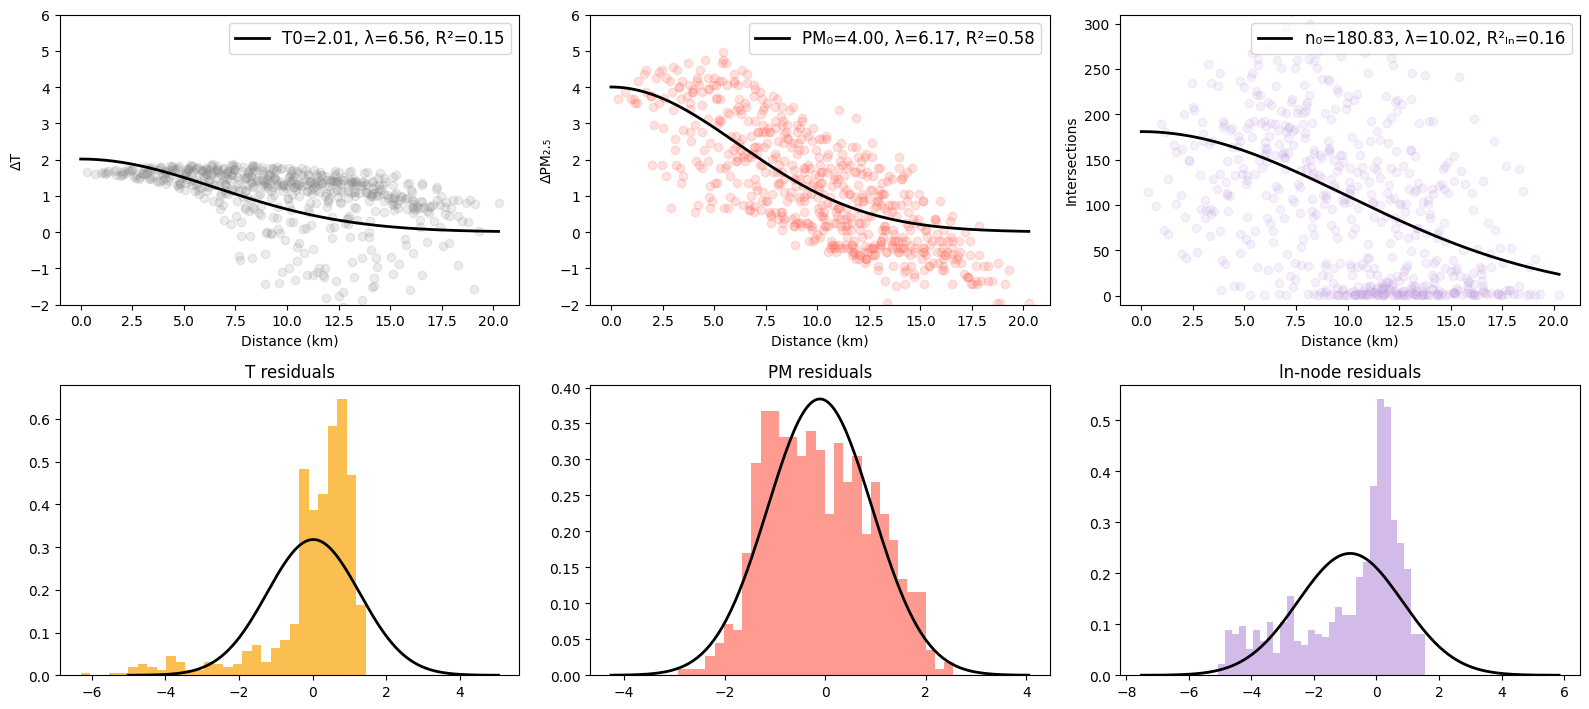

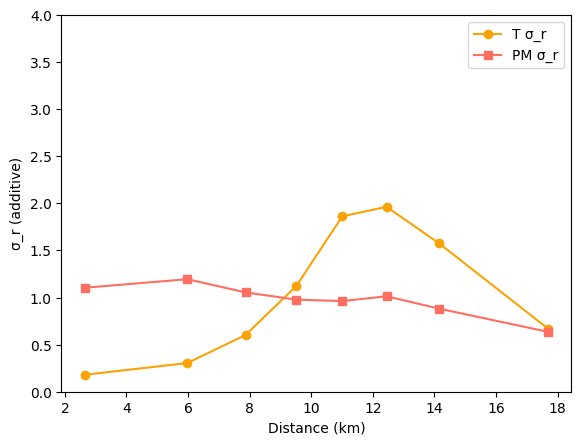

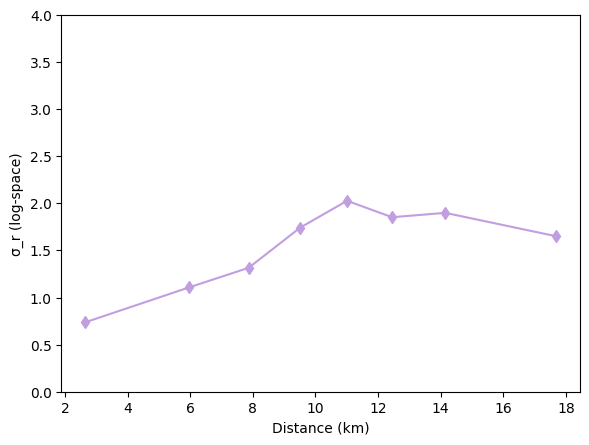

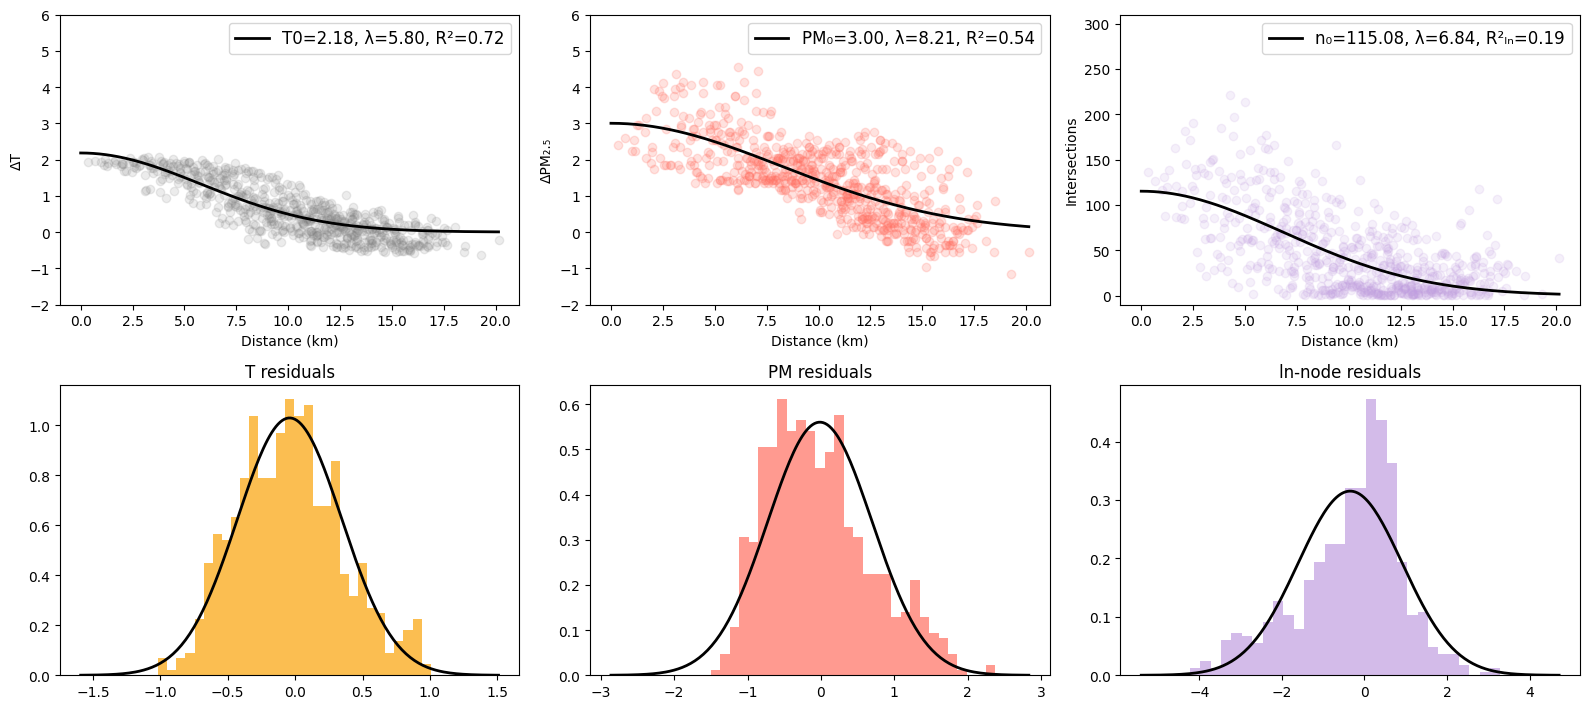

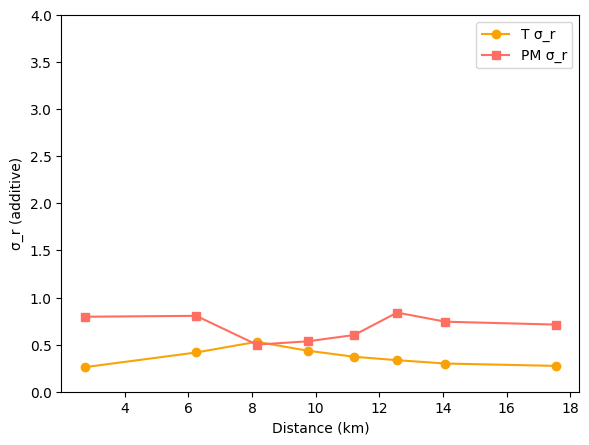

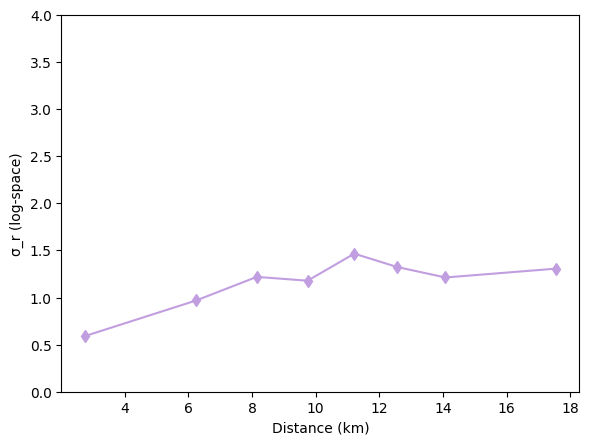

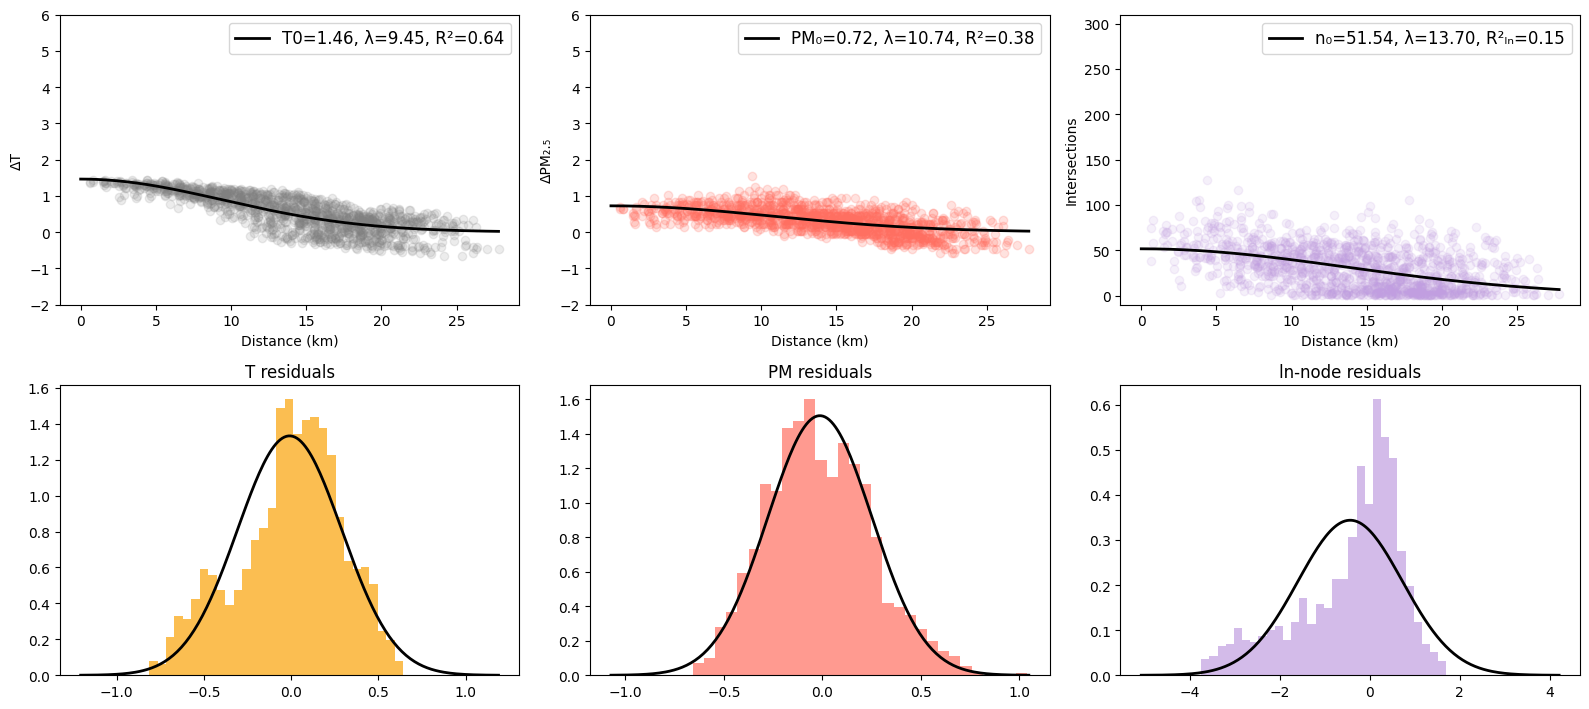

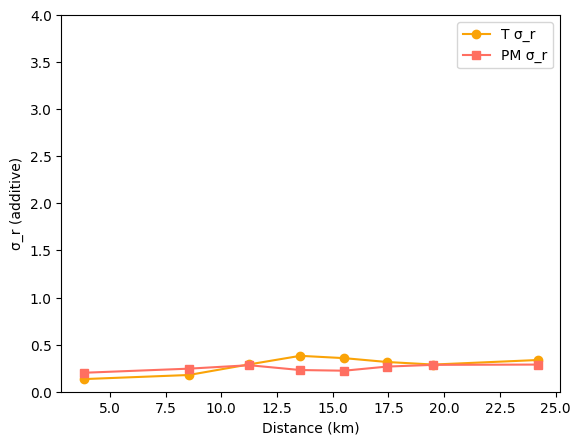

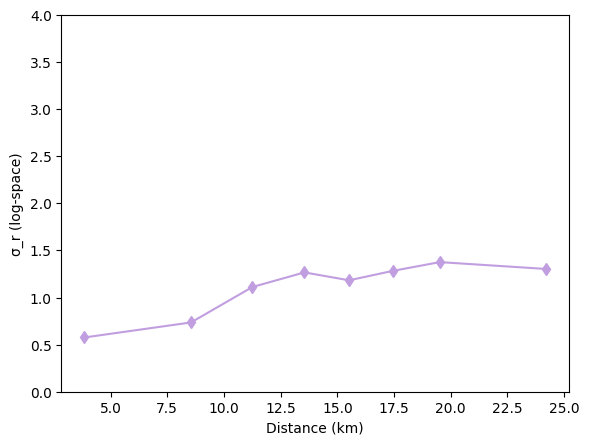

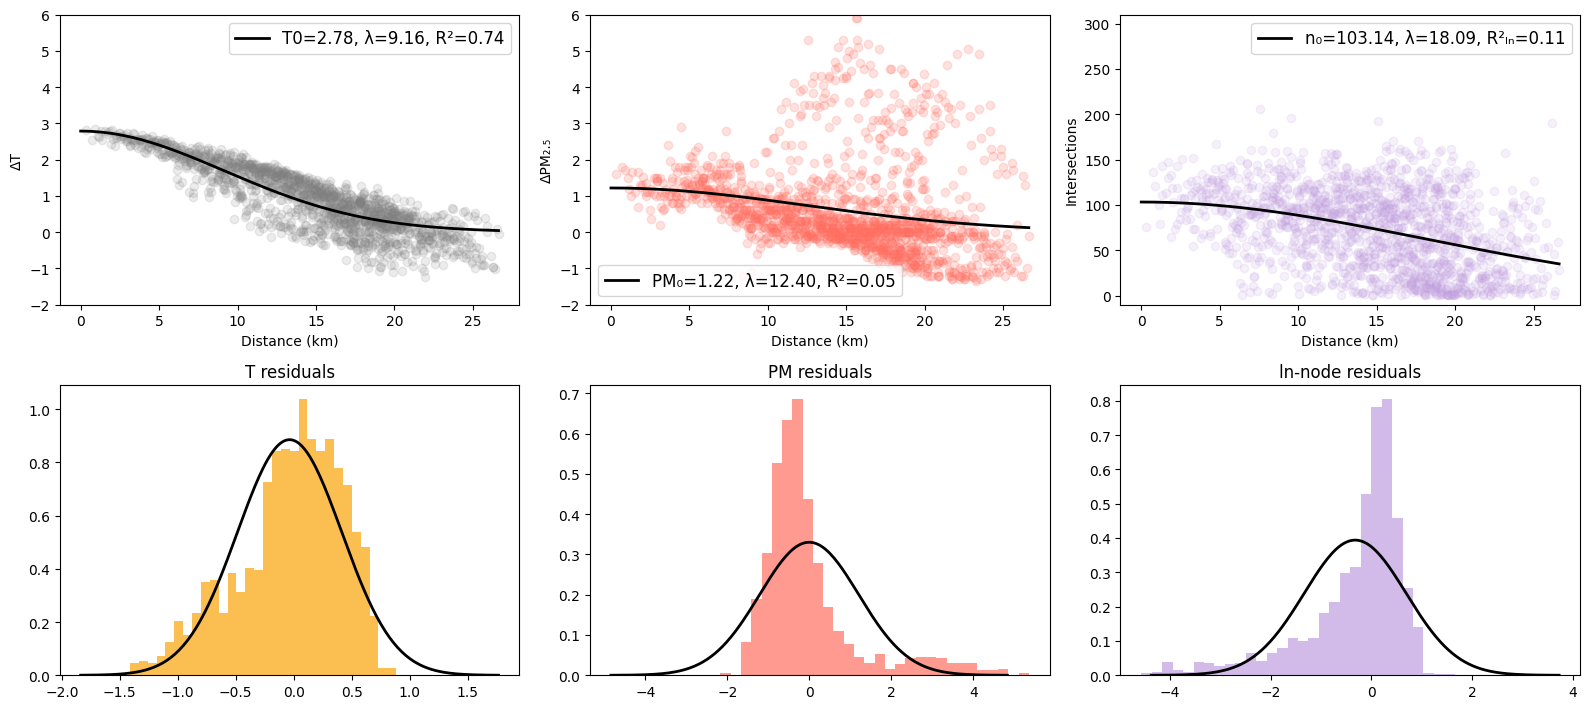

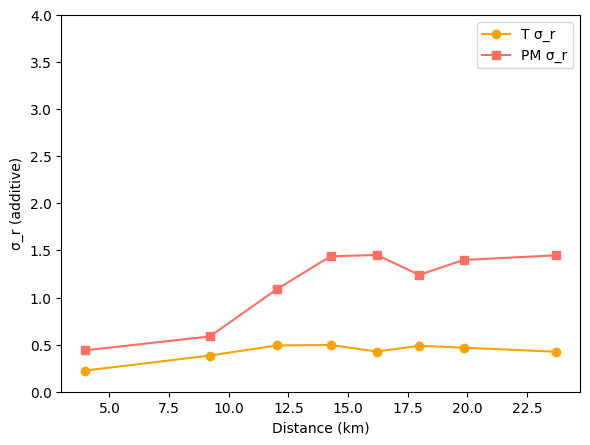

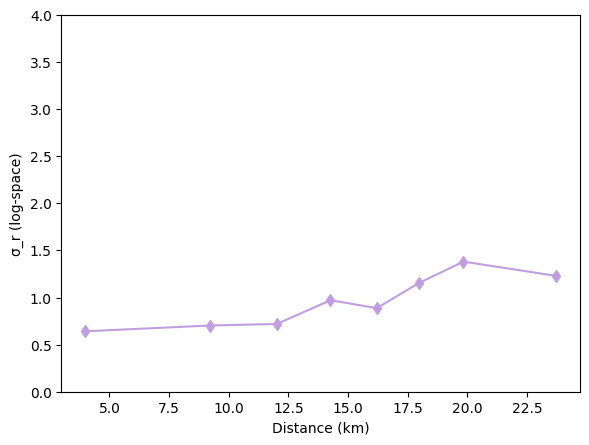

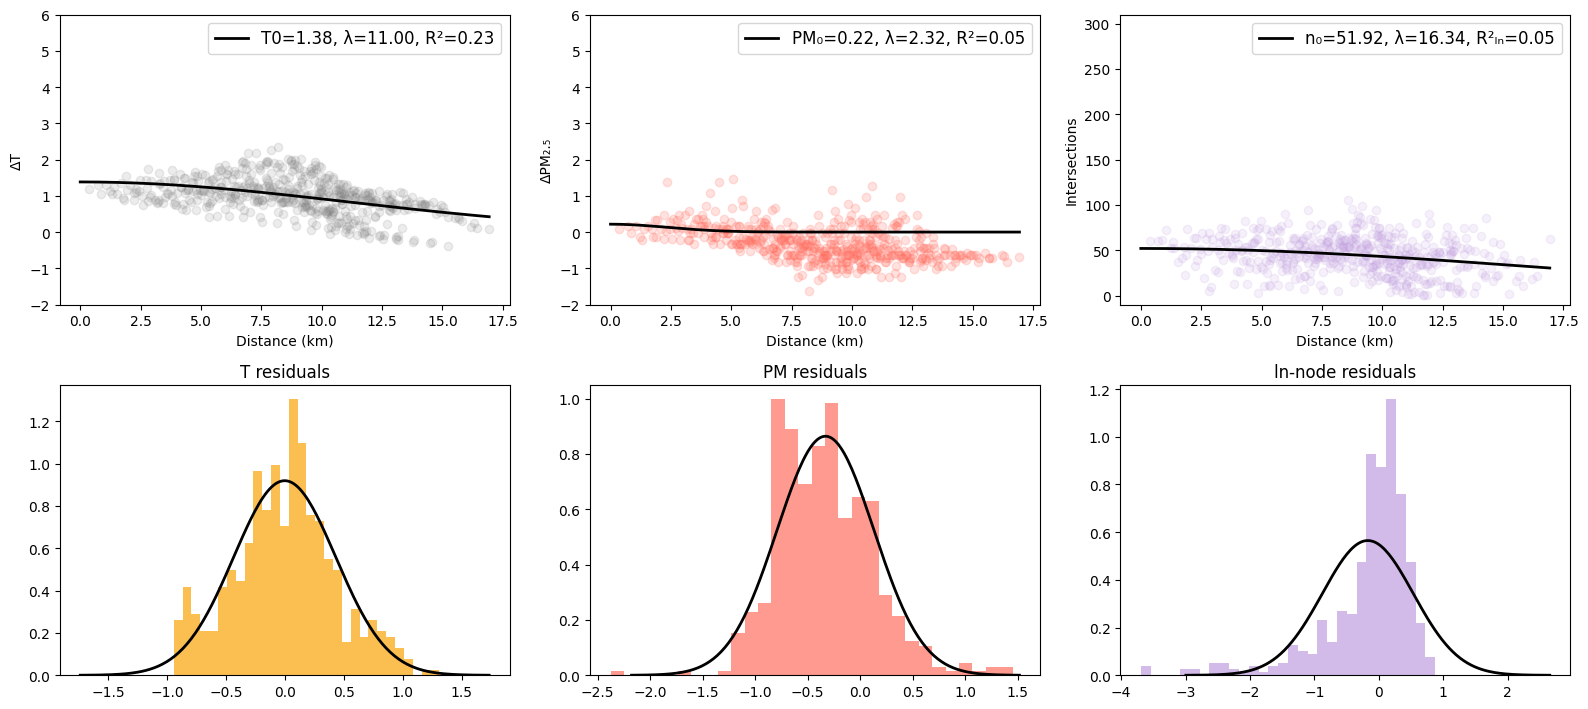

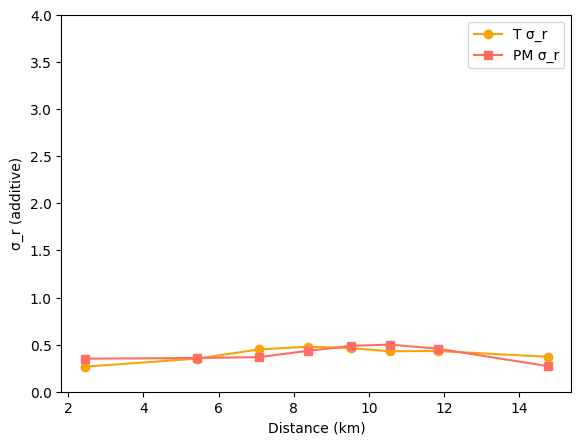

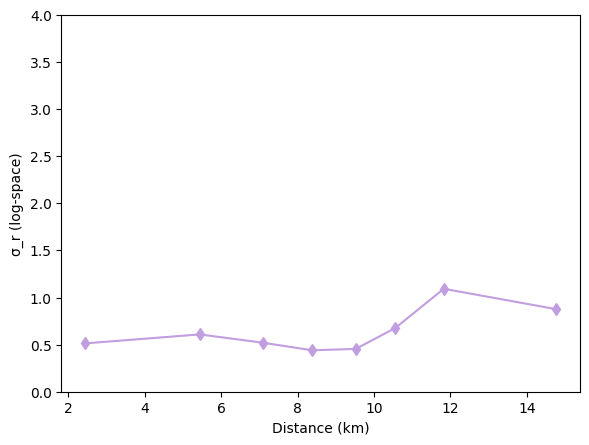

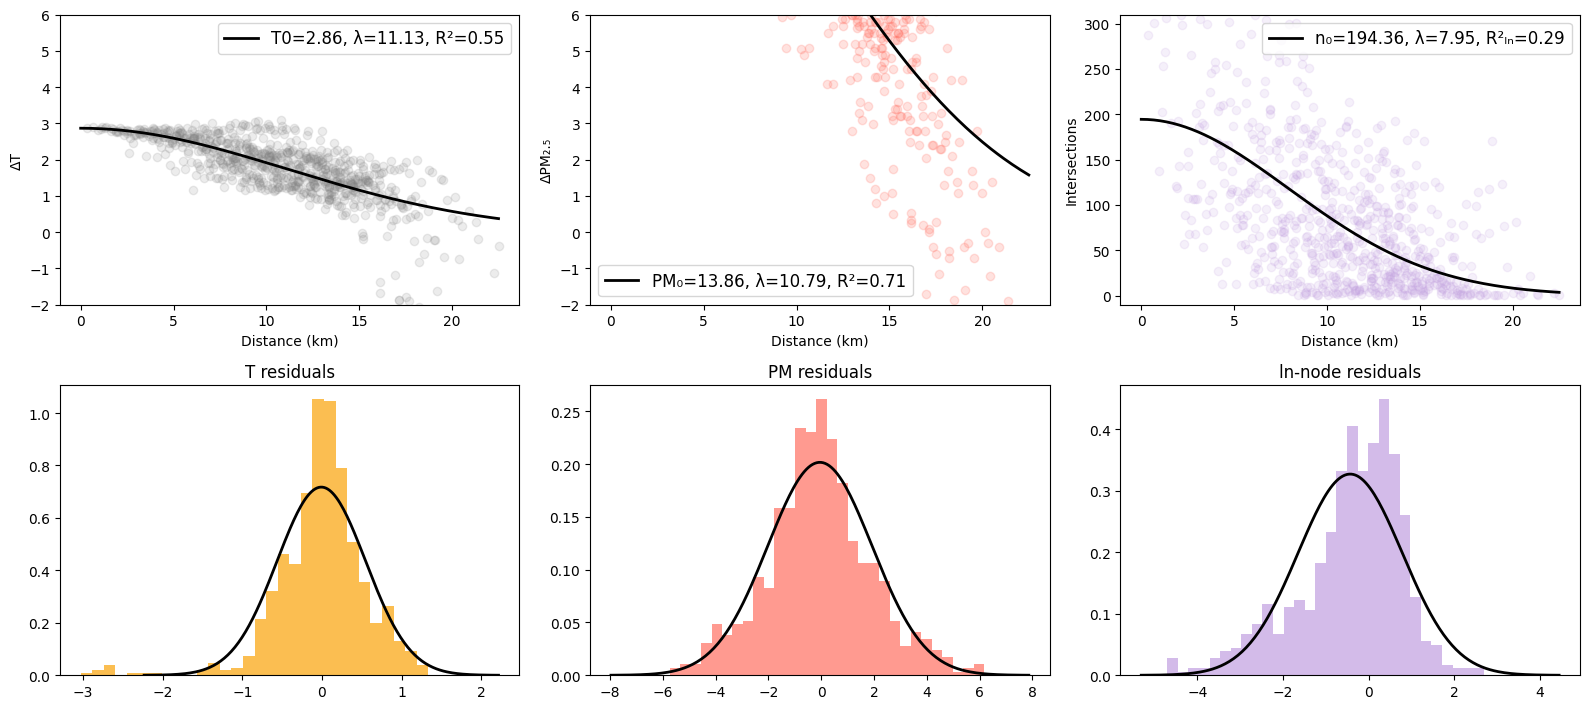

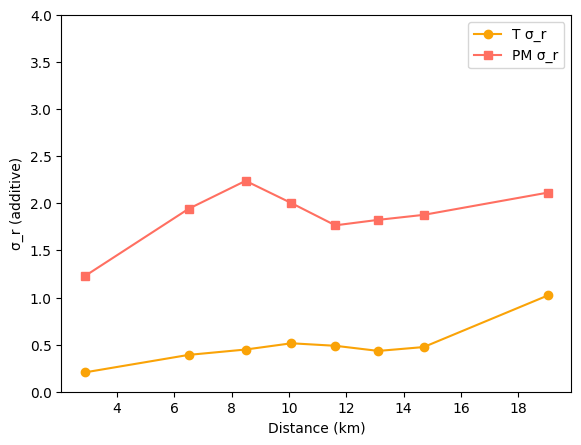

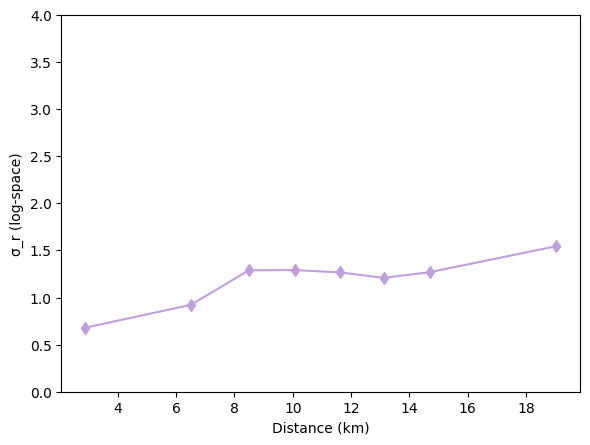

In [22]:
os.chdir(r'C:\Users\mduran\Desktop\PhD- Patterns and Dynamics in Urban Networks\1- DATA POLLUTION - Scaling laws, pdfs\RESULTS_GLOBAL') 

def gaussian_decay(r, A0, lam):
    return A0 * np.exp(-r**2 / (2 * lam**2))

cities_plot = ['Bogota', 'Bucharest', 'Berlin', 'Paris', 'Toronto', 'Islamabad'] 
PM = '25'

for city in cities_plot:
    df = pop_T_NETWORK_dic[city]
    
    r = df['r'].to_numpy() / 1000.0 # distances in km
    T = df['deltaT'].to_numpy()
    PM25 = df[f'deltaPM{PM}'].to_numpy()
    n = df['node'].to_numpy()

    # --- 1) Fit each decay ---
    # temperature (additive noise)
    pT, _ = curve_fit(gaussian_decay, r, T, p0=[T.max(), r.std()])
    T0_fit, lam_T = pT
    T_fit = gaussian_decay(r, *pT)
    res_T = T - T_fit
    r2_T = 1 - np.var(res_T)/np.var(T)

    # PM2.5 (additive noise)
    pP, _ = curve_fit(gaussian_decay, r, PM25, p0=[PM25.max(), r.std()])
    PM0_fit, lam_PM = pP
    PM_fit = gaussian_decay(r, *pP)
    res_PM = PM25 - PM_fit
    r2_PM = 1 - np.var(res_PM)/np.var(PM25)

    # street intersections (multiplicative noise)
    pn, _ = curve_fit(gaussian_decay, r, n, p0=[n.max(), r.std()])
    n0_fit, lam_n = pn
    n_fit = gaussian_decay(r, *pn)
    res_ln_n = np.log(n + 1e-9) - np.log(n_fit + 1e-9)
    r2_n = 1 - np.var(res_ln_n)/np.var(np.log(n + 1e-9))

    thr = np.percentile(r, 10)
    mask_out = r >= thr

    # 2) Plots
    fig = plt.figure(figsize=(16,7.2))

    # — T decay
    ax1 = fig.add_subplot(2,3,1)
    ax1.scatter(r, T, color='grey', alpha=0.15)
    rs = np.linspace(0, r.max(), 200)
    ax1.plot(rs, gaussian_decay(rs, T0_fit, lam_T), 'k-', lw=2,
             label=f'T0={T0_fit:.2f}, λ={lam_T:.2f}, R²={r2_T:.2f}')
    ax1.set(xlabel='Distance (km)', ylabel=r'ΔT', ylim=(-2,6))
    ax1.legend(fontsize=12)

    # — PM decay
    ax2 = fig.add_subplot(2,3,2)
    ax2.scatter(r, PM25, color='#ff6f61', alpha=0.2)
    ax2.plot(rs, gaussian_decay(rs, PM0_fit, lam_PM), 'k-', lw=2,
             label=f'PM₀={PM0_fit:.2f}, λ={lam_PM:.2f}, R²={r2_PM:.2f}')
    ax2.set(xlabel='Distance (km)', ylabel=r'ΔPM₂.₅', ylim=(-2,6))
    ax2.legend(fontsize=12)

    # — node decay
    ax3 = fig.add_subplot(2,3,3)
    ax3.scatter(r, n, color='#c19ee0', alpha=0.15)
    ax3.plot(rs, gaussian_decay(rs, n0_fit, lam_n), 'k-', lw=2,
             label=f'n₀={n0_fit:.2f}, λ={lam_n:.2f}, R²ₗₙ={r2_n:.2f}')
    ax3.set(xlabel='Distance (km)', ylabel='Intersections', ylim=(-10,310))
    ax3.legend(fontsize=12)

    # — residual histograms —
    # temperature
    ax4 = fig.add_subplot(2,3,4)
    ax4.hist(res_T, bins=30, density=True, color='#faa307', alpha=0.7)
    μ, σ = res_T.mean(), res_T.std()
    x = np.linspace(μ-4*σ, μ+4*σ, 200)
    ax4.plot(x, norm.pdf(x,μ,σ),'k-',lw=2)
    ax4.set(title='T residuals')

    # PM
    ax5 = fig.add_subplot(2,3,5)
    ax5.hist(res_PM, bins=30, density=True, color='#ff6f61', alpha=0.7)
    μ, σ = res_PM.mean(), res_PM.std()
    x = np.linspace(μ-4*σ, μ+4*σ, 200)
    ax5.plot(x, norm.pdf(x,μ,σ),'k-',lw=2)
    ax5.set(title='PM residuals')

    # log‑node
    ax6 = fig.add_subplot(2,3,6)
    ax6.hist(res_ln_n, bins=30, density=True, color='#c19ee0', alpha=0.7)
    μ, σ = res_ln_n.mean(), res_ln_n.std()
    x = np.linspace(μ-4*σ, μ+4*σ, 200)
    ax6.plot(x, norm.pdf(x,μ,σ),'k-',lw=2)
    ax6.set(title='ln‑node residuals')

    plt.tight_layout()
    plt.savefig(f'{city}_decay_and_residuals.svg', dpi=300)
    plt.show()

    # 3) Belt‑based σ_r
    nbins = 8 if r.max()>10 else 5
    edges = np.percentile(r, np.linspace(0,100,nbins+1))
    centers = 0.5*(edges[:-1]+edges[1:])

    σT_belt, σPM_belt, σlnN_belt = [], [], []
    for i in range(nbins):
        m = (r>=edges[i]) & (r<edges[i+1])
        if m.sum()>1:
            σT_belt.append(res_T[m].std())
            σPM_belt.append(res_PM[m].std())
            σlnN_belt.append(res_ln_n[m].std())
        else:
            σT_belt.append(np.nan)
            σPM_belt.append(np.nan)
            σlnN_belt.append(np.nan)

    plt.figure(figsize=(6,4.5))
    plt.plot(centers, σT_belt, 'o-', color='#faa307', label='T σ_r')
    plt.plot(centers, σPM_belt,'s-', color='#ff6f61', label='PM σ_r')
    plt.xlabel('Distance (km)'); plt.ylabel(r'σ_r (additive)')
    plt.legend(); plt.tight_layout()
    plt.ylim(0,4)
    # plt.savefig(f'{city}_sigma_climate.svg', dpi=300)
    plt.show()

    # plot node σ_r in log‑space
    plt.figure(figsize=(6,4.5))
    plt.plot(centers, σlnN_belt, 'd-', color='#c19ee0', label='ln‑node σ_r')
    plt.xlabel('Distance (km)'); plt.ylabel(r'σ_r (log‑space)')
    plt.tight_layout()
    plt.ylim(0,4)
    # plt.savefig(f'{city}_sigma_node.svg', dpi=300)
    plt.show()

## HISTOGRAMS DECAY MODEL

### CLIMATE VARIABLES

In [16]:
os.chdir(r'C:\Users\mduran\Desktop\PhD- Patterns and Dynamics in Urban Networks\1- DATA POLLUTION - Scaling laws, pdfs\RESULTS_GLOBAL') 

def plot_variable(data_T, data_PM, xmin, xmax, xlabel, filename, step=None, num_bins=None, bin_range=None, custom_xticks=None):

    # 1) Clean the data
    data_T_clean = data_T[~np.isnan(data_T) & ~np.isinf(data_T)]
    data_PM_clean = data_PM[~np.isnan(data_PM) & ~np.isinf(data_PM)]
    
    # 2) Determine bin range
    if bin_range is None:
        bin_range = (xmin, xmax)
    
    # 3) Create bins 
    if step is not None:
        bins = np.arange(bin_range[0], bin_range[1] + step, step)
    else:
        if num_bins is None:
            num_bins = 10  # default value if nothing is provided
        bins = np.linspace(bin_range[0], bin_range[1], num_bins+1)
    
    # 4) Create normalized weights
    if len(data_T_clean) == 0:
        data_T_clean = np.array([0.0])
    if len(data_PM_clean) == 0:
        data_PM_clean = np.array([0.0])
    
    weights_T  = np.ones_like(data_T_clean)  / len(data_T_clean)
    weights_PM = np.ones_like(data_PM_clean) / len(data_PM_clean)
    
    # 5) Plot overlapping histograms
    plt.figure(figsize=figsize)
    plt.hist(data_T_clean, bins=bins, color=color_T, alpha=0.6, edgecolor='black',
             weights=weights_T, label='Temperature')
    plt.hist(data_PM_clean, bins=bins, color=color_PM, alpha=0.6, edgecolor='black',
             weights=weights_PM, label='Pollution')
    
    # 6) Compute Pearson correlation 
    mask = (~np.isnan(data_T) & ~np.isnan(data_PM) &
            ~np.isinf(data_T) & ~np.isinf(data_PM))
    data_T_corr = data_T[mask]
    data_PM_corr = data_PM[mask]
    
    if len(data_T_corr) > 1:
        r_value, _ = pearsonr(data_T_corr, data_PM_corr)
    else:
        r_value = np.nan
    
    # 7) Final labeling, custom ticks and saving
    plt.xlabel(xlabel, fontsize=22) #22,30
    plt.ylabel('Fraction of cities', fontsize=22)
    plt.tick_params(axis='x', labelsize=18) #18,26
    plt.tick_params(axis='y', labelsize=18)
    plt.legend(fontsize=18, loc='upper left')
    
    plt.tight_layout()
    plt.xlim(xmin, xmax)
    plt.ylim(0, 0.8)
    plt.yticks([0, 0.4,0.8])

    if custom_xticks is not None:
        plt.xticks(custom_xticks)
    
    # plt.savefig(filename, format='svg', dpi=600, bbox_inches='tight')
    plt.show()

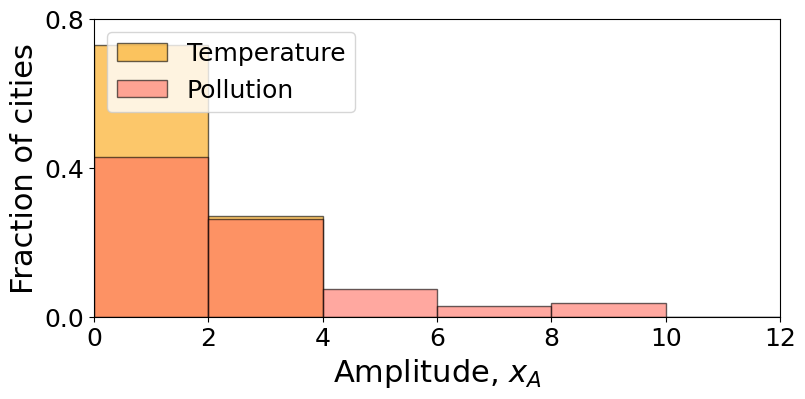

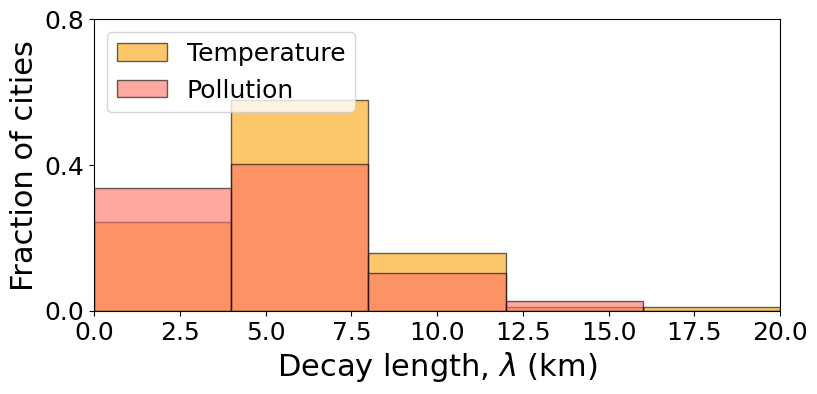

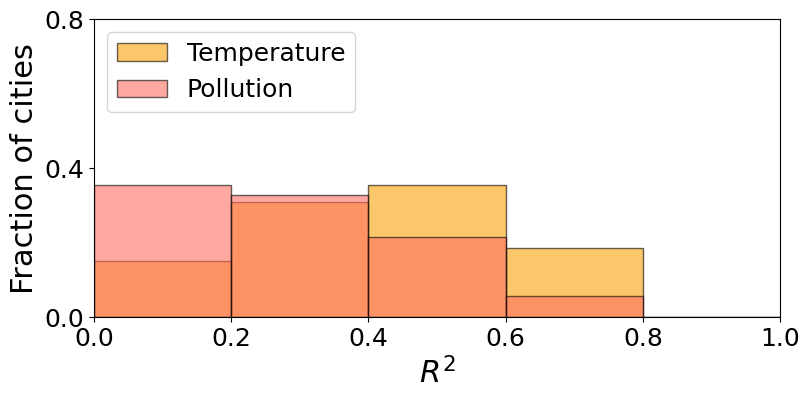

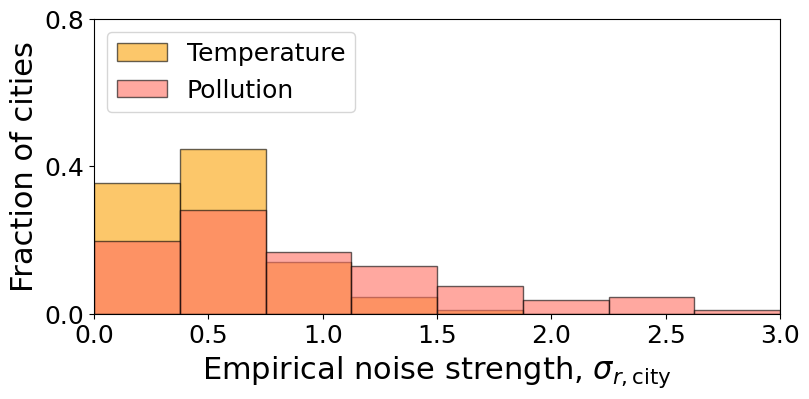

In [17]:
# ------------------------------------------------------------
# 1) CLIMATE VARIABLES (T y PM)
# ------------------------------------------------------------

color_PM = "#ff6f61"
color_T  = "#faa307"

figsize=(8, 4)


plot_variable(
    np.array(T0),
    np.array(PM0),
    xmin=0, xmax=12,
    xlabel='Amplitude, $x_A$',
    filename='Amplitude_climate.svg',
    step=2
)

plot_variable(
    np.array(λ_T),
    np.array(λ_PM),
    xmin=0, xmax=20,
    xlabel='Decay length, $\\lambda$ (km)',
    filename='DecayLength_climate.svg',
    step=4
)

plot_variable(
    np.array(R2_T),
    np.array(R2_PM),
    xmin=0, xmax=1,
    xlabel=r'$R^2$',
    filename='R2_climate.svg',
    step=0.2,
    bin_range=(0, 1)
)

plot_variable(
    np.array(σ_T),
    np.array(σ_PM),
    xmin=0, xmax=3,
    xlabel = r'Empirical noise strength, $\sigma_{r,\mathrm{city}}$',
    filename='Sigma_climate.svg',
    step=0.375,
    bin_range=(0, 3),
    custom_xticks=np.arange(0, 3.01, 0.5)
)

### STREET NETWORK

In [18]:
os.chdir(r'C:\Users\mduran\Desktop\PhD- Patterns and Dynamics in Urban Networks\1- DATA POLLUTION - Scaling laws, pdfs\RESULTS_GLOBAL') 

node_color = "#c19ee0"

def plot_node_variable(data, xmin, xmax, xlabel, filename, step=None, num_bins=None, bin_range=None, custom_xticks=None):

    # 1) Clean the data
    data_clean = data[~np.isnan(data) & ~np.isinf(data)]
    
    # 2) Determine the bin range
    if bin_range is None:
        bin_range = (xmin, xmax)
        
    # 3) Create bins
    if step is not None:
        bins = np.arange(bin_range[0], bin_range[1] + step, step)
    else:
        if num_bins is None:
            num_bins = 10 
        bins = np.linspace(bin_range[0], bin_range[1], num_bins+1)
    
    # 4) Create normalized weights--> histogram shows the fraction of cities
    if len(data_clean) == 0:
        data_clean = np.array([0.0])
    weights = np.ones_like(data_clean) / len(data_clean)
    
    # 5) Plot the histogram
    figsize = (10, 6)
    plt.figure(figsize=figsize)

    plt.hist(data_clean, bins=bins, color=node_color, alpha=0.6, edgecolor='black', weights=weights, label='Street network')
    
    # 6) Labeling and ticks
    plt.xlabel(xlabel, fontsize=30)
    plt.ylabel('Fraction of cities', fontsize=30)
    plt.tick_params(axis='x', labelsize=26)
    plt.tick_params(axis='y', labelsize=26)
    
    plt.tight_layout()
    plt.xlim(xmin, xmax)
    plt.ylim(0, 0.8)
    plt.yticks([0, 0.2, 0.4, 0.6, 0.8])
    
    if custom_xticks is not None:
        plt.xticks(custom_xticks)

    plt.legend(fontsize=26, loc='best')
        
    # plt.savefig(filename, format='svg', dpi=600, bbox_inches='tight')
    plt.show()


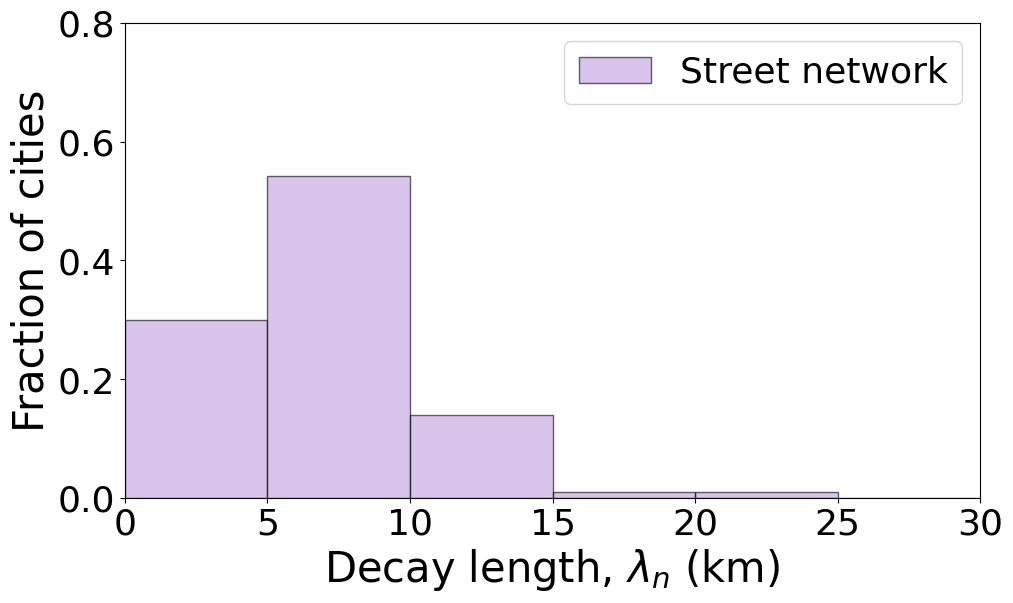

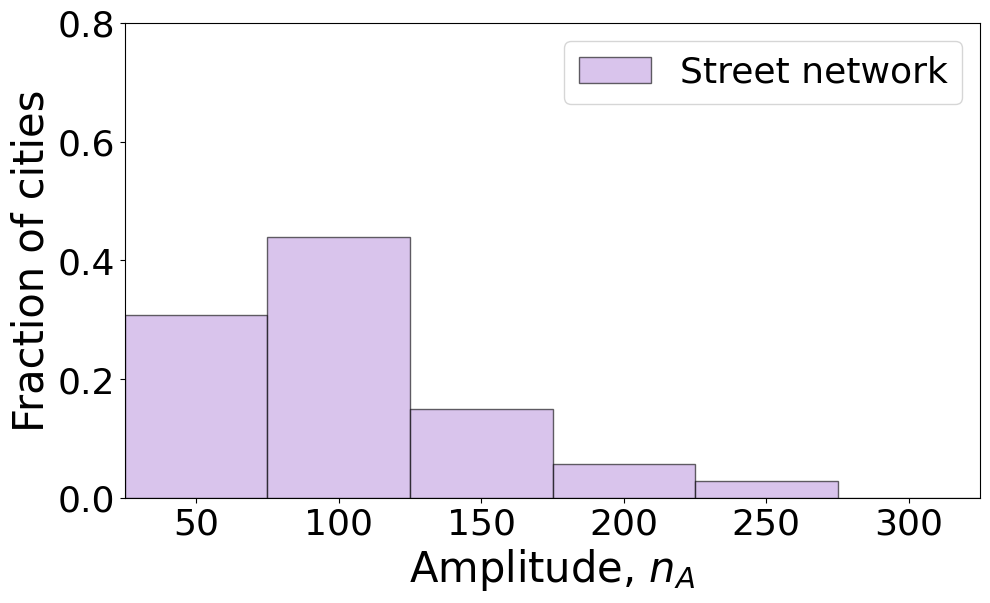

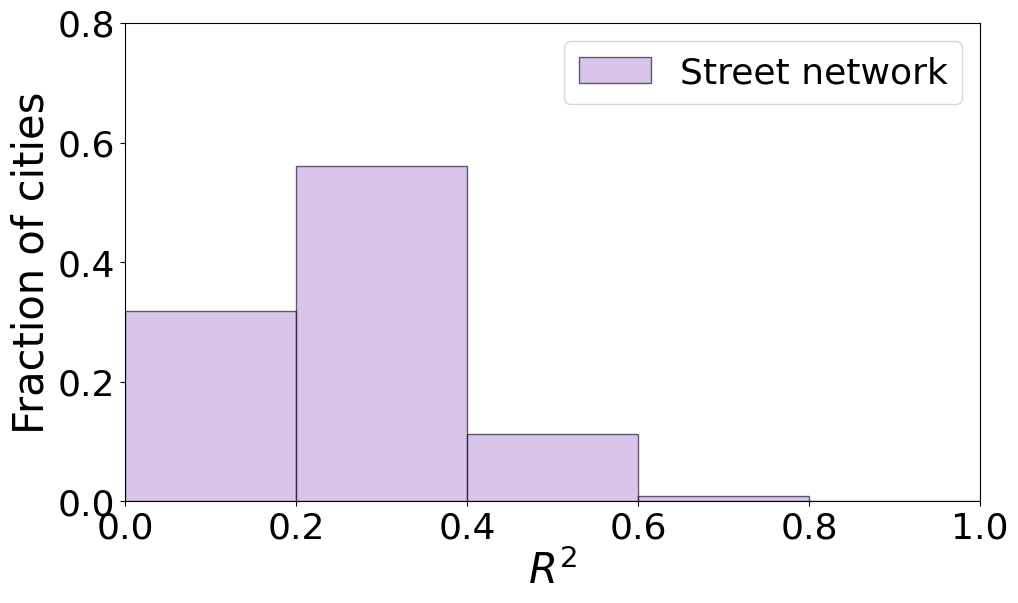

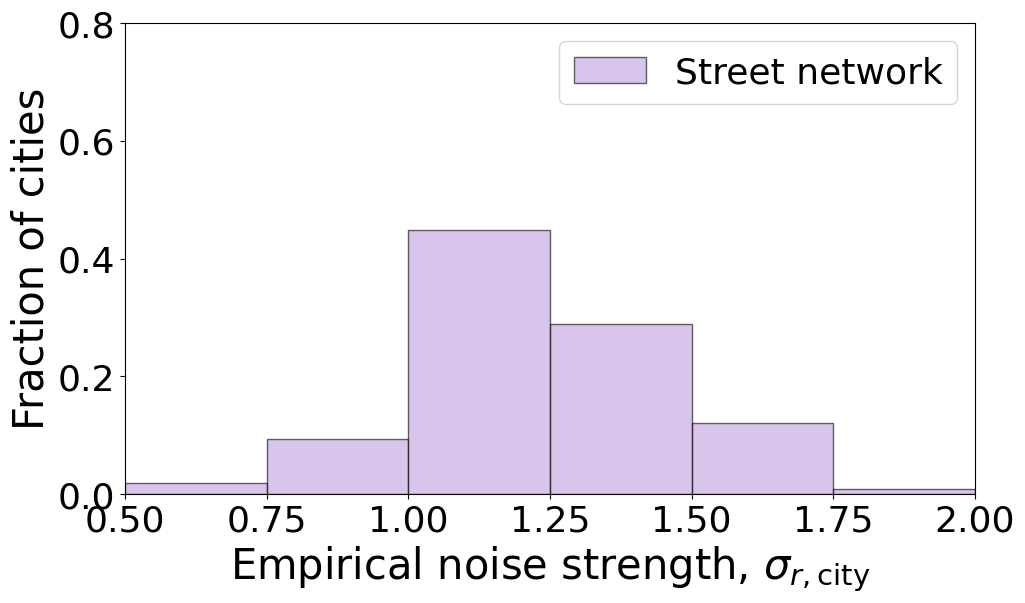

In [19]:
# ------------------------------------------------------------
# 1) HISTOGRAMAS: STREET NETWORK
# ------------------------------------------------------------

plot_node_variable(np.array(λ_node),
                   xmin=0, xmax=30,
                   xlabel=r'Decay length, $\lambda_n$ (km)',
                   filename='NodeDecayLength.svg',
                   step=5)

plot_node_variable(np.array(A_node),
                   xmin=25, xmax=325,
                   xlabel=r'Amplitude, $n_A$',
                   filename='NodeAmplitude.svg',
                   step=50)

plot_node_variable(np.array(R2_node),
                   xmin=0, xmax=1,
                   xlabel=r'$R^2$',
                   filename='NodeR2.svg',
                   step=0.2)

plot_node_variable(np.array(σlog_node),
                   xmin=0.5, xmax=2,
                   xlabel=r'Empirical noise strength, $\sigma_{r,\mathrm{city}}$',
                   filename='Sigma_node.svg',
                   step=0.25)


## PEARSON CORRELATIONS

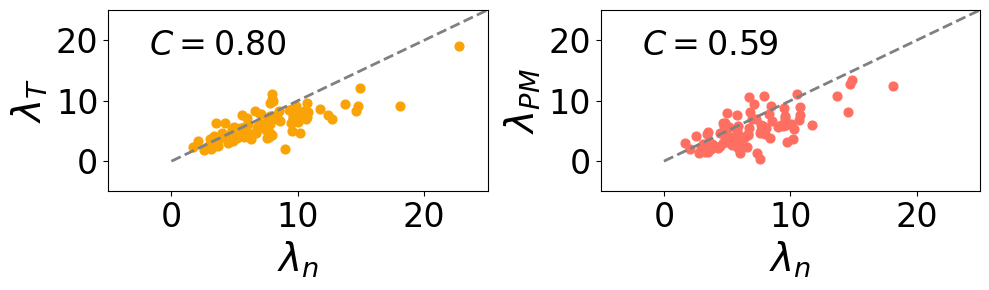

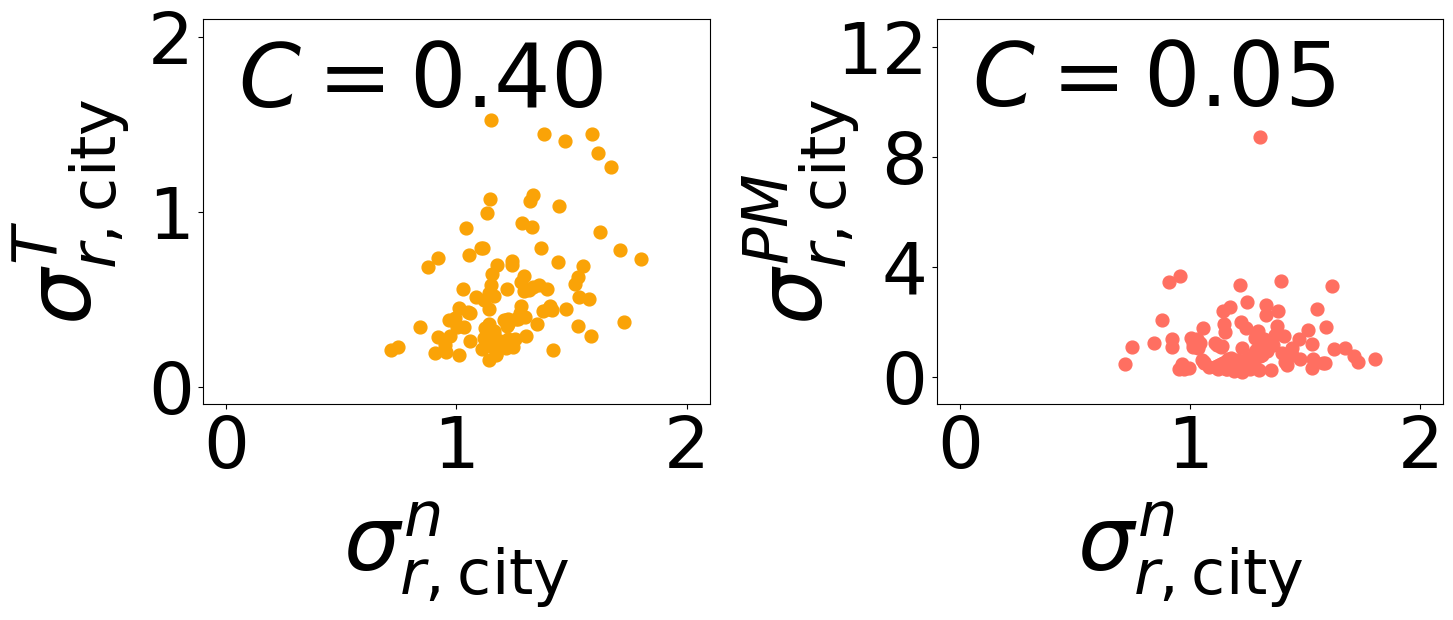

In [33]:
os.chdir(r'C:\Users\mduran\Desktop\PhD- Patterns and Dynamics in Urban Networks\1- DATA POLLUTION - Scaling laws, pdfs\RESULTS_GLOBAL') 

lam_node     = λ_node      # intersections decay length
lam_T        = λ_T         # temperature decay length
lam_PM       = λ_PM        # PM2.5 decay length
cv_node      = σlog_node   # street‐network multiplicative CV
sigma_T_abs  = σ_T         # temperature absolute noise
sigma_PM_abs = σ_PM        # PM2.5 absolute noise

cv_node_plot   = cv_node.copy()        # σ_log-n
sigma_T_plot   = sigma_T_abs.copy()    # σ_T (°C)
sigma_PM_plot  = sigma_PM_abs.copy()   # σ_PM (μg/m³)

mask_keep = cv_node_plot <= 3.5
cv_node_plot   = cv_node_plot[mask_keep]
sigma_T_plot   = sigma_T_plot[mask_keep]
sigma_PM_plot  = sigma_PM_plot[mask_keep]


mask1_plot = (~np.isnan(lam_node)) & (~np.isnan(lam_T)) & (lam_node > 0) & (lam_T > 0) & (lam_T < 1000)
mask2_plot = (~np.isnan(lam_node)) & (~np.isnan(lam_PM)) & (lam_node > 0) & (lam_PM > 0) & (lam_PM < 1000)
mask5_plot = ~np.isnan(cv_node_plot) & ~np.isnan(sigma_T_plot)
mask6_plot = ~np.isnan(cv_node_plot) & ~np.isnan(sigma_PM_plot)

r1, p1 = pearsonr(lam_node[mask1_plot], lam_T[mask1_plot])
r2, p2 = pearsonr(lam_node[mask2_plot], lam_PM[mask2_plot])
r5, p5 = pearsonr(cv_node_plot[mask5_plot], sigma_T_plot[mask5_plot])
r6, p6 = pearsonr(cv_node_plot[mask6_plot], sigma_PM_plot[mask6_plot])

color_T  = "#faa307"
color_PM = "#ff6f61"

# ----------------------------------------------------

maxλ  = np.nanmax([lam_node, lam_T, lam_PM])
xdiag = np.linspace(0, 30, 100)

lam_PM_plot = lam_PM.copy()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
ax1.scatter(lam_node[mask1_plot], lam_T[mask1_plot], s=40, color=color_T)
ax1.plot(xdiag, xdiag, '--', color='gray', lw=2)
ax1.set_xlim(-5, 25)
ax1.set_ylim(-5, 25)
ax1.set_xlabel(r'$\lambda_{n}$', fontsize=28)
ax1.set_ylabel(r'$\lambda_{T}$', fontsize=28)
ax1.tick_params(axis='x', labelsize=24)
ax1.tick_params(axis='y', labelsize=24)
ax1.set_xticks([0, 10, 20])
ax1.set_yticks([0, 10, 20])
ax1.text(-1.75, 17.5, rf'$C={r1:.2f}$', fontsize=24)

ax2.scatter(lam_node[mask2_plot], lam_PM_plot[mask2_plot], s=40, color=color_PM)
ax2.plot(xdiag, xdiag, '--', color='gray', lw=2)
ax2.set_xlim(-5, 25)
ax2.set_ylim(-5, 25)
ax2.set_xlabel(r'$\lambda_{n}$', fontsize=28)
ax2.set_ylabel(r'$\lambda_{PM}$', fontsize=28)
ax2.tick_params(axis='x', labelsize=24)
ax2.tick_params(axis='y', labelsize=24)
ax2.set_xticks([0, 10, 20])
ax2.set_yticks([0, 10, 20])
ax2.text(-1.75, 17.5, rf'$C={r2:.2f}$', fontsize=24)

plt.tight_layout()

# plt.savefig('decay_params_comparison.svg', format='svg', dpi=600, bbox_inches='tight')

plt.show()

# ----------------------------------------------------

maxN   = np.nanmax([cv_node, sigma_T_abs, sigma_PM_abs])
xdiagN = np.linspace(0, 20, 100)

fig, (ax5, ax6) = plt.subplots(1, 2, figsize=(16, 5), gridspec_kw={'wspace': 0.45})

ax5.scatter(cv_node_plot[mask5_plot], sigma_T_plot[mask5_plot], s=85, color=color_T)
ax5.set_xlabel(r'$\sigma_{r,\mathrm{city}}^{n}$', fontsize=64, labelpad=12)
ax5.set_ylabel(r'$\sigma_{r,\mathrm{city}}^{T}$', fontsize=64, labelpad=12)
ax5.set_xlim(-0.1, 2.1)
ax5.set_ylim(-0.1, 2.1)
ax5.set_xticks([0, 1, 2])
ax5.set_yticks([0, 1, 2])
ax5.tick_params(axis='both', labelsize=52)
ax5.text(0.05, 1.6, rf'$C={r5:.2f}$', fontsize=64)

ax6.scatter(cv_node_plot[mask6_plot], sigma_PM_plot[mask6_plot], s=85, color=color_PM)
ax6.set_xlabel(r'$\sigma_{r,\mathrm{city}}^{n}$', fontsize=64, labelpad=12)
ax6.set_ylabel(r'$\sigma_{r,\mathrm{city}}^{PM}$', fontsize=64, labelpad=-19)
ax6.set_xlim(-0.1, 2.1)
ax6.set_ylim(-1, 13)
ax6.set_xticks([0, 1, 2])
ax6.set_yticks([0, 4, 8, 12])
ax6.tick_params(axis='both', labelsize=52)
ax6.text(0.05, 9.85, rf'$C={r6:.2f}$', fontsize=64)

plt.tight_layout()

# plt.savefig('noise_params_comparison.svg', format='svg', dpi=600, bbox_inches='tight')

plt.show()